# Lean, Mean, Stats Machine: Final Project Data Scraping
---
Welcome, presumably, John! This is the web scraping portion of my work for the Final Project. 

In this code, I will be outlining the steps I had taken in order to webscrape the data relevant for our project via various packages, but mainly using the [Newscatcher Library](https://github.com/kotartemiy/newscatcher).

### Set-up
---
Super simple, just the relevant packages for setting up the webscraping.

Here are the key packages which you may not be familiar with:
- [TQDM](https://tqdm.github.io/)
    - This package makes a progress bar to help track the run of long-running loops.
- [Selenium](https://www.selenium.dev/)
    - An automatic browser which allows the run of dynamically loaded HTML.

In [36]:
# Import necessary libraries
import json
import csv
import numpy  as np 
import pandas as pd 
from datetime import datetime
from datetime import timedelta
from glob import glob

# Webscraping Libraries
from bs4  import BeautifulSoup as bs
from tqdm import tqdm
import requests
import sys
import time
from selenium import webdriver 
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options

# Visualizing some data
import matplotlib.pyplot as plt
import seaborn as sns

# Multi-threading for faster scraping
from multiprocessing import Pool
import concurrent.futures

# Libraries for text processing
import re
import string
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus        import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stopwords = stopwords.words('english')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\quach\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\quach\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Initiate the Webscrape
---
"Left" leaning news outlets were chosen based off of political lean ratings determined by [AllSides](https://www.allsides.com/about) which is a media solutions company which establishes a third-party review of the political affilation and perspectives which various media outlets display. They also provide community-based tools which help establish an agreement and validity scale of their results by permitting users to vote on whether or not they agree or disagree with the lean they deem on a website.

From here, I'll initiate the webscraping using `Newscatcher` for
- [Vox Media](https://www.vox.com/) which declared bankruptcy recently lol.
    - AllSides gives it a score of -4 indicating that it is a solid Left lean.
- [HuffPost](https://www.huffpost.com/) which is owned by BuzzFeed apparently.
    - AllSides gives it a score of -4.3 indicating that it as a solid Left lean.
- [The New Yorker](https://www.newyorker.com/) which is different than the New York Times.
    - Allsides gives it a score of -4.2 indicating that it is a solid Left lean.

In [8]:
# Load the csv file into a dataframe
vox_df = pd.read_csv('vox_headlines_FULL_BACKUP.csv', index_col=0)

In [9]:
# Load the dataframe into a dictionary
vox_results = vox_df.to_dict(orient='index')

In [4]:
def get_vox_news(from_:str, to_:str):
    '''
    Performs webscraping of the archieve 

    Parameters
    ----------
    from_ (str): Start date of the search in the format YYYY-MM
    to_ (str):   End date of the search in the format YYYY-MM

    Returns
    -------
    dict: Dictionary containing news headlines, links, dates, and media source
    '''
    # Configure Selenium Webdriver
    chromeOptions = Options()
    chromeOptions.add_argument("--headless=new")
    driver = webdriver.Chrome(options=chromeOptions)

    # Utilize beautiful soup to scrape the Vox archive
    main_url = 'https://www.vox.com/archives'

    # Relevant fields for search
    optimized_feature = 'data-chorus-optimize-field'
    analytic_feature = 'data-analytics-link'

    # Generate list of relevant dates to search from the Vox archive
    dates = pd.date_range(from_, to_, freq='MS').strftime("%Y/%#m").tolist()

    # Search through the archive within dates
    all_headlines = {}
    with tqdm(total=len(dates)) as pbar:
        for date in dates:
            dated_url = f'{main_url}/{date}'
            driver.get(dated_url)

            # Continue to press the "Load More" button while it is clickable
            while True:
                try:
                    # Wait for "Load More" button to be clickable
                    load_more = WebDriverWait(driver, 10, 8).until(
                        EC.element_to_be_clickable((By.CLASS_NAME, 'c-archives-load-more__button')
                    )) # Little reminder that CLASS_NAME can only be singular, no spaces
                    load_more.click()
                except:
                    break
            
            # Create a BeautifulSoup object
            soup = bs(driver.page_source, 'html.parser')

            # Find all the <a> tags
            headlines = soup.find_all('a', {optimized_feature: 'hed', analytic_feature: True})
            times     = soup.find_all('time', {'class': 'c-byline__item', 'data-ui': 'timestamp'})

            # Add headlines to dictionary as key and links and date as values
            for headline, time in zip(headlines, times):
                all_headlines[headline.text] = {
                    "link": headline['href'],
                    "date": time['datetime'][:10],
                    "source": "Vox"
                }
            
            # Update the progress bar
            pbar.update()
    driver.quit()
    return all_headlines

In [8]:
vox_results = get_vox_news('2019-03', '2023-05')

100%|██████████| 51/51 [16:12<00:00, 19.07s/it]  


In [19]:
fixed_dates_2023 = get_vox_news('2023-03', '2023-03')

100%|██████████| 1/1 [01:30<00:00, 90.62s/it]


In [5]:
# Merge the two dictionaries and overwrite the original for duplicates
vox_results.update(fixed_dates_2023)

NameError: name 'fixed_dates_2023' is not defined

In [10]:
vox_df = pd.DataFrame.from_dict(vox_results, orient='index')
# Sort the data by date
vox_df.sort_values(by='date', inplace=True)

In [11]:
dates = vox_df['date'].str.slice(stop=7)
date_counts = dates.value_counts().sort_index()

date_counts.tail(18)

date
2021-12    191
2022-01    189
2022-02    191
2022-03    218
2022-04    196
2022-05    196
2022-06    235
2022-07    193
2022-08    210
2022-09    195
2022-10    271
2022-11    223
2022-12    202
2023-01    183
2023-02    195
2023-03    229
2023-04    247
2023-05    257
Name: count, dtype: int64

In [12]:
# Export the vox_df to a csv file
vox_df.to_csv('vox_headlines.csv', encoding='utf-8-sig', chunksize=None)

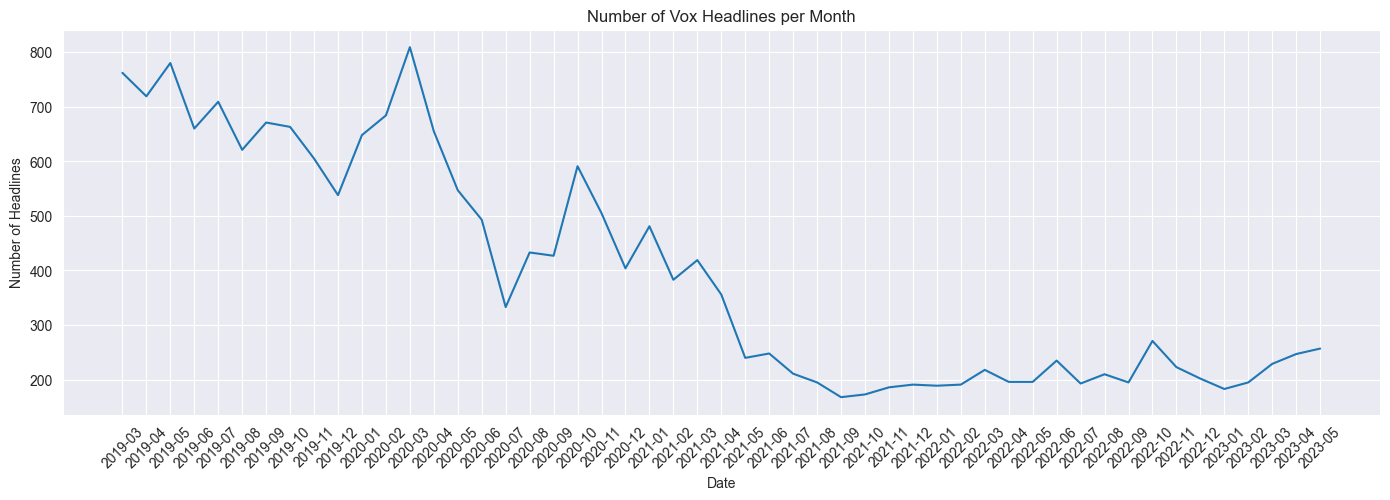

In [12]:
# Plot the number of headlines per month
sns.set_style('darkgrid')
plt.figure(figsize=(17, 5))
plt.plot(date_counts)
plt.title('Number of Vox Headlines per Month')
plt.xlabel('Date')
plt.ylabel('Number of Headlines')
plt.xticks(rotation=45)
plt.show()


In [9]:
def get_content(link: str) -> str:
    '''
    Gathers the content of the article from the link

    Parameters
    ----------
    link (str): Link to the article

    Returns
    -------
    str: Content of the article
    '''
    # Uses simple requests to get the content of the article
    totalTime = 0
    response = requests.get(link)
    soup = bs(response.content, 'html.parser')
    content = soup.find_all('p')
    # Wait and retry if the content is empty
    while (len(content) == 0) and (totalTime < 300):
        time.sleep(30)
        totalTime += 30
        response = requests.get(link)
        soup = bs(response.content, 'html.parser')
        content = soup.find_all('p')
    # Remove the last 7 paragraphs which is not part of the article
    content = content[:-7]
    print(link)
    return '\n'.join([c.text for c in content])

In [10]:
def process_links(links: list) -> list:
    '''
    Processes the links in parallel using multithreading

    Parameters
    ----------
    df (pd.DataFrame): Dataframe containing the links

    Returns
    -------
    list: List of article contents
    '''
    # Create a pool of workers to execute processes
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Execute the processes and return the results
        futures = [executor.submit(get_content, link) for link in links]

        # Wait for the processes to finish and return the results
        results = [future.result() for future in concurrent.futures.as_completed(futures)]

    return results

In [11]:
# Split the dataframe into 5 parts for each of the 5 years
vox_2019 = vox_df[vox_df['date'].str.contains('2019')]
vox_2020 = vox_df[vox_df['date'].str.contains('2020')]
vox_2021 = vox_df[vox_df['date'].str.contains('2021')]
vox_2022 = vox_df[vox_df['date'].str.contains('2022')]
vox_2023 = vox_df[vox_df['date'].str.contains('2023')]

# Put each of these dataframes into a list
vox_dfs = [vox_2019, vox_2020, vox_2021, vox_2022, vox_2023]

### Processing the Links for the Articles
---
This next section gets really long and so a lot of the code is broken up into sections to permit reusability.

In [ ]:
# Process the links of each year with multithreading
# Add confirmations to prevent accidental execution
for i, df in enumerate(vox_dfs):
    print(f'Processing {i+1} of 5')
    confirmation = input('Continue? (y/n): ')
    if confirmation == 'y':
        # Get the content of the articles
        df['content'] = process_links(df['link'].tolist())
        # Export the dataframe to a csv file
        df.to_csv(f'vox_{i+1}.csv', encoding='utf-8-sig', chunksize=None)
    else:
        print('Skipping...')

In [ ]:
# Return to each of the dfs and fill in the missing values
vox_2023_empty = vox_2023[vox_2023['content'] == '']
vox_2023_empty['content'] = process_links(vox_2023_empty.loc[:,'link'].tolist())

vox_2022_empty = vox_2022[vox_2022['content'] == '']
vox_2022_empty['content'] = process_links(vox_2023_empty.loc[:,'link'].tolist())

vox_2021_empty = vox_2021[vox_2021['content'] == '']
vox_2021_empty['content'] = process_links(vox_2023_empty.loc[:,'link'].tolist())

vox_2020_empty = vox_2020[vox_2020['content'] == '']
vox_2020_empty['content'] = process_links(vox_2023_empty.loc[:,'link'].tolist())

vox_2019_empty = vox_2019[vox_2019['content'] == '']
vox_2019_empty['content'] = process_links(vox_2023_empty.loc[:,'link'].tolist())

In [ ]:
# Drop rows within the dataframe that have no content
vox_2019.drop(vox_2019_empty.index)
vox_2020.drop(vox_2020_empty.index)
vox_2021.drop(vox_2021_empty.index)
vox_2022.drop(vox_2022_empty.index)
vox_2023.drop(vox_2023_empty.index)

# Concatenate the yearly dataframes
vox_df = pd.concat([vox_2019, vox_2020, vox_2021, vox_2022, vox_2023, vox_2023_empty, vox_2022_empty, vox_2021_empty, vox_2020_empty, vox_2019_empty])

# Sort the data by date
vox_df.sort_values(by='date', inplace=True)

In [ ]:
# Export each of the dataframes to a csv file
# Add confirmations to prevent accidental execution
for i, df in enumerate(vox_dfs):
    print(f'Exporting {i+1} of 5')
    confirmation = input('Continue? (y/n): ')
    if confirmation == 'y':
        df.to_csv(f'vox_{i+1}.csv', encoding='utf-8-sig', chunksize=None)
    else:
        print('Skipping...')

In [42]:
# Combine all the dataframes into one
vox_df_full = pd.concat([vox_2019, vox_2020, vox_2021, vox_2022, vox_2023])

In [43]:
vox_df_full

,link,date,source,content
I have always been a True Detective skeptic. Season 3 made a believer.,https://www.vox.com/culture/2019/3/1/18243121/...,2019-03-01,Vox,"The eerie, thoughtful third installment was a ..."
"Under Amazon, Whole Foods prices were expected to decrease. Instead, they’re rising.",https://www.vox.com/the-goods/2019/2/12/182222...,2019-03-01,Vox,"In an exchange about the price of rude emails,..."
"The arcane procedural drama that has House Democrats seething, explained",https://www.vox.com/policy-and-politics/2019/3...,2019-03-01,Vox,The speech lasted for more than two hours.\nTh...
"The brewing fight over making the Mueller report public, explained",https://www.vox.com/2019/3/1/18233814/mueller-...,2019-03-01,Vox,Washington Gov. Jay Inslee dishes on the Green...
Undocumented immigrants pay millions of dollars in state taxes — even in the reddest states,https://www.vox.com/2019/3/1/18241692/undocume...,2019-03-01,Vox,"If it sounds beyond parody, that’s because it ..."
...,...,...,...,...
The Cannes movies everyone will be talking about this year,https://www.vox.com/culture/23738614/cannes-20...,2023-05-28,Vox,So you heard TikTok’s being banned. Here’s wha...
How anti-LGBTQ sentiment is affecting Pride,https://www.vox.com/2023/5/28/23740489/pride-a...,2023-05-28,Vox,Let’s not find out what happens to the economy...
Succession ends exactly how it needed to,https://www.vox.com/tv/23740949/succession-sea...,2023-05-29,Vox,"Because of them, Sudan is at risk of falling i..."
"Reality, starring Sydney Sweeney, is unsettling, vital viewing",https://www.vox.com/culture/23733989/reality-w...,2023-05-29,Vox,The new Indiana Jones movie hits different in ...


In [50]:
# Export the dataframe to a csv file
vox_df_full.to_csv('vox_df_full.csv', encoding='utf-8-sig', chunksize=None)

In [51]:
# Read the csv file containing all the vox articles
vox_df_full_check = pd.read_csv('vox_df_full.csv', index_col=0)
vox_df_full_check

,link,date,source,content
I have always been a True Detective skeptic. Season 3 made a believer.,https://www.vox.com/culture/2019/3/1/18243121/...,2019-03-01,Vox,"The eerie, thoughtful third installment was a ..."
Gradients: the colorful design trend aiming to soothe these anxious times,https://www.vox.com/the-goods/2019/3/1/1824159...,2019-03-01,Vox,“There are better ways to do that than just wr...
AT&T’s WarnerMedia shake-up tells you how it views the future of media,https://www.vox.com/2019/2/28/18245643/hbo-att...,2019-03-01,Vox,"The IFC show is tailor-made for a tiny, passio..."
What’s next after the Trump-Kim summit? An expert explains.,https://www.vox.com/world/2019/2/28/18245123/t...,2019-03-01,Vox,"The company says voice shopping is so popular,..."
Vox Sentences: Trump gets nothing,https://www.vox.com/vox-sentences/2019/2/28/18...,2019-03-01,Vox,Believe in Logan Green and John Zimmer. Or don...
...,...,...,...,...
Why don’t more voters care about the debt ceiling?,https://www.vox.com/politics/2023/5/28/2373881...,2023-05-28,Vox,From “fluffy flying narwhals” to maggots that ...
What Erdogan’s win means for the West — and the world,https://www.vox.com/world-politics/2023/5/28/2...,2023-05-28,Vox,Harsh state policies imply it’s not — but what...
"Reality, starring Sydney Sweeney, is unsettling, vital viewing",https://www.vox.com/culture/23733989/reality-w...,2023-05-29,Vox,The new Indiana Jones movie hits different in ...
"In defense of flies. Yes, really.",https://www.vox.com/down-to-earth/23736015/fli...,2023-05-29,Vox,5 questions about the debt ceiling and the loo...


## Cleaning up the entire dataset
---
Now that we have the full dataset, let's clean it up to make sure that it's in the correct format

In [2]:
# load in the full dataset
vox_df_full = pd.read_csv('vox_df_full_backup.csv', index_col=0)

In [3]:
# Parse out the date from each of the articles and then add them in by year, month, and day
vox_df_full['date'] = pd.to_datetime(vox_df_full['date'])

vox_df_full['year'] = vox_df_full['date'].apply(lambda x: x.year)
vox_df_full['month'] = vox_df_full['date'].apply(lambda x: x.month)
vox_df_full['day'] = vox_df_full['date'].apply(lambda x: x.day)

In [4]:
# Add the index as a new column called headline
vox_df_full['headline'] = vox_df_full.index

# Reindex the dataframe to just use numbers
vox_df_full.reset_index(drop=True, inplace=True)

In [5]:
# Drop the link column
vox_df_full.drop('link', axis=1, inplace=True)

In [6]:
# Reorder the columns to headline, source, content, date, year, month, day
vox_df_full = vox_df_full[['headline', 'source', 'content', 'date', 'year', 'month', 'day']]

In [46]:
# Drop the rows that have no content
vox_df_full.dropna(inplace=True)
vox_df_full

,headline,source,content,date,year,month,day
0,I have always been a True Detective skeptic. S...,Vox,"The eerie, thoughtful third installment was a ...",2019-03-01,2019,3,1
1,Gradients: the colorful design trend aiming to...,Vox,“There are better ways to do that than just wr...,2019-03-01,2019,3,1
2,AT&T’s WarnerMedia shake-up tells you how it v...,Vox,"The IFC show is tailor-made for a tiny, passio...",2019-03-01,2019,3,1
3,What’s next after the Trump-Kim summit? An exp...,Vox,"The company says voice shopping is so popular,...",2019-03-01,2019,3,1
4,Vox Sentences: Trump gets nothing,Vox,Believe in Logan Green and John Zimmer. Or don...,2019-03-01,2019,3,1
...,...,...,...,...,...,...,...
20133,Why don’t more voters care about the debt ceil...,Vox,From “fluffy flying narwhals” to maggots that ...,2023-05-28,2023,5,28
20134,What Erdogan’s win means for the West — and th...,Vox,Harsh state policies imply it’s not — but what...,2023-05-28,2023,5,28
20135,"Reality, starring Sydney Sweeney, is unsettlin...",Vox,The new Indiana Jones movie hits different in ...,2023-05-29,2023,5,29
20136,"In defense of flies. Yes, really.",Vox,5 questions about the debt ceiling and the loo...,2023-05-29,2023,5,29


In [47]:
totArticle = len(vox_df_full)

In [48]:
def preprocess_article(article: str):
    '''
    Preprocess the article content by removing punctuation, numbers, and stopwords and tokenizing the words

    Parameters
    ----------
    article: str

    Returns
    -------
    None
    '''
    global totArticle

    article = article.lower()
    article = article.translate(str.maketrans('', '', string.punctuation))

    # Remove all non-alphanumeric characters
    article = re.sub(r'[^A-Za-z0-9 ]+', '', article)
    
    # Convert all the string into a collection of singular words
    content = nltk.word_tokenize(article)
   
    # Remove all the stopwords
    content = [word for word in content if (word not in stopwords)]

    # Reduce all words into their stemmed form
    stemmer = SnowballStemmer('english')
    content = [stemmer.stem(word) for word in content]

    # Finixh preproccessing by joining all the words
    final = ' '.join(content)
    totArticle -= 1
    print(f'{totArticle} articles remaining', end='\r')
    return final

In [49]:
# Preprocess the content of each article
vox_df_full['process_content'] = vox_df_full['content'].apply(preprocess_article)

In [50]:
vox_df_full

,headline,source,content,date,year,month,day,process_content
0,I have always been a True Detective skeptic. S...,Vox,"The eerie, thoughtful third installment was a ...",2019-03-01,2019,3,1,eeri thought third instal terrif medit abus po...
1,Gradients: the colorful design trend aiming to...,Vox,“There are better ways to do that than just wr...,2019-03-01,2019,3,1,better way write checkth earli 2020 democrat p...
2,AT&T’s WarnerMedia shake-up tells you how it v...,Vox,"The IFC show is tailor-made for a tiny, passio...",2019-03-01,2019,3,1,ifc show tailormad tini passion fan baseyeah t...
3,What’s next after the Trump-Kim summit? An exp...,Vox,"The company says voice shopping is so popular,...",2019-03-01,2019,3,1,compani say voic shop popular doesnt need dash...
4,Vox Sentences: Trump gets nothing,Vox,Believe in Logan Green and John Zimmer. Or don...,2019-03-01,2019,3,1,believ logan green john zimmer dontyou wouldnt...
...,...,...,...,...,...,...,...,...
20133,Why don’t more voters care about the debt ceil...,Vox,From “fluffy flying narwhals” to maggots that ...,2023-05-28,2023,5,28,fluffi fli narwhal maggot snorkel trash welcom...
20134,What Erdogan’s win means for the West — and th...,Vox,Harsh state policies imply it’s not — but what...,2023-05-28,2023,5,28,harsh state polici impli studi say friend babi...
20135,"Reality, starring Sydney Sweeney, is unsettlin...",Vox,The new Indiana Jones movie hits different in ...,2023-05-29,2023,5,29,new indiana jone movi hit differ ip agein 1981...
20136,"In defense of flies. Yes, really.",Vox,5 questions about the debt ceiling and the loo...,2023-05-29,2023,5,29,5 question debt ceil loom xdate answer debt ce...
